In [1]:
# !pip uninstall keras-cv keras-nlp tensorflow-text tensorflow -y
# !pip install --upgrade git+https://github.com/keras-team/keras-cv -q
# !pip install keras-nlp
# !pip install tensorflow-text==2.15.0
# !pip install tensorflow==2.15.0
# !pip install tensorflow opencv-python pytesseract
# !pip install matplotlib

In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import pytesseract
from PIL import Image, ImageFilter, ImageEnhance

/Users/ajgrover/Documents/H195B/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-22 21:14:29.067748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [3]:
BATCH_SIZE = 5
LEARNING_RATE = 0.0001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

class_ids = ['cardcorner']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
# path_train = "train"
# path_valid = "valid"

def create_dataset(data_path):
  xml_files = sorted(
      [
          os.path.join(data_path, file_name)
          for file_name in os.listdir(data_path)
          if file_name.endswith(".xml")
      ]
  )

  jpg_files = sorted(
      [
          os.path.join(data_path, file_name)
          for file_name in os.listdir(data_path)
          if file_name.endswith(".jpg")
      ]
  )
  print(f"Found {len(jpg_files)} images")


  def parse_annotation(xml_file):
      tree = ET.parse(xml_file)
      root = tree.getroot()

      image_name = root.find("filename").text
      image_path = os.path.join(data_path, image_name)

      boxes = []
      classes = []
      for obj in root.iter("object"):
          cls = obj.find("name").text
          classes.append(cls)

          bbox = obj.find("bndbox")
          xmin = float(bbox.find("xmin").text)
          ymin = float(bbox.find("ymin").text)
          xmax = float(bbox.find("xmax").text)
          ymax = float(bbox.find("ymax").text)
          boxes.append([xmin, ymin, xmax, ymax])

      class_ids = [
          list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
          for cls in classes
      ]
      return image_path, boxes, class_ids

  image_paths = []
  bbox = []
  classes = []
  for xml_file in tqdm(xml_files):
      image_path, boxes, class_ids = parse_annotation(xml_file)
      image_paths.append(image_path)
      bbox.append(boxes)
      classes.append(class_ids)
  print("image_paths: ", len(image_paths))
  print("bbox: ", len(bbox))
  print("classes: ", len(classes))

  bbox = tf.ragged.constant(bbox)
  classes = tf.ragged.constant(classes)
  image_paths = tf.ragged.constant(image_paths)

  data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
  return data

# train_data = create_dataset(path_train)
# val_data = create_dataset(path_valid)

In [4]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

model1 = "YOLO_model/JUSTMYDATA/big_model.keras"
model2 = "YOLO_model/ALSODANKRAD_serialaug/big_model.keras"

##TODO: SWITCH TO MODEL 2 HERE

loaded_model = keras.saving.load_model(model1, custom_objects=class_mapping, compile=False)
loaded_model.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou", jit_compile=False
)

/Users/ajgrover/Documents/H195B/.venv/lib/python3.9/site-packages/keras_cv/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/ajgrover/Documents/H195B/.venv/lib/python3.9/site-packages/keras_cv/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1/1 [==============================] - 27s 27s/step


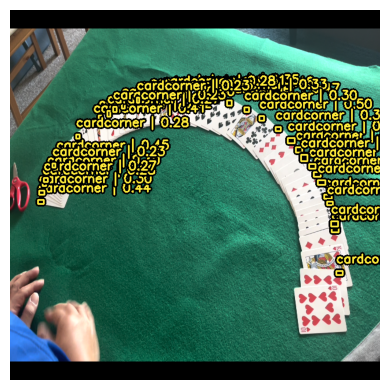

In [5]:
def load_image_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    resized = tf.image.resize(image, [640, 640])
    resized = tf.reshape(resized, [1, 640, 640, 3])
    return resized

def predict_image(image, visualize=False):
    test_img = load_image_path(image)
    y_pred = loaded_model.predict(test_img)
    if visualize:
        visualization.plot_bounding_box_gallery(
            test_img,
            value_range=(0, 255),
            bounding_box_format="xyxy",
            y_pred=y_pred,
            scale=4,
            rows=1,
            cols=1,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
    return y_pred

predict_image("full_test.png", visualize=True);

In [25]:
def visualize_and_recognize_text_sorted(model, dataset, bounding_box_format="xyxy"):
    print("Getting image...")
    # images, y_true = next(iter(dataset.take(1)))
    images = load_image_path("full_test.png")
    print("Running inference...")
    y_pred = model.predict(images)
    
    print("Processing detections...")
    valid_ranks = {'2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'}
    valid_suits = {'♥', '♦', '♣', '♠'}  # Suit symbols
    for i in range(len(images)):
        image = images[i].numpy().astype(np.uint8)
        detections = y_pred['boxes'][i]
        texts_with_xmin = []

        for box in detections:
            xmin, ymin, xmax, ymax = map(int, box[:4])
            if xmin < 0 or xmax < 0 or ymin < 0 or ymax < 0:
                continue
            cropped_image = image[int(ymin*.98):int(ymax*1.02), int(xmin*.98):int(xmax*1.02)]
            img = Image.fromarray(cropped_image)
            # im = img.filter(ImageFilter.MedianFilter())
            enhancer = ImageEnhance.Contrast(img)
            im = enhancer.enhance(2)
            # im = im.convert('1')
            im.show()

            # Adjust the whitelist for symbols
            text = pytesseract.image_to_string(im, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=2345678910JjQqKkAa♥♦♣♠').strip()
            if text:
                texts_with_xmin.append((xmin, text))

        texts_with_xmin.sort(key=lambda x: x[0])
        return texts_with_xmin
        # rank = next((text for _, text in texts_with_xmin if text in valid_ranks), None)
        # suit = next((text for _, text in texts_with_xmin if text in valid_suits), None)

        # if not rank or not suit:
        #     print("Error: Rank or Suit not recognized properly.")
        # else:
        #     print("\nRecognized Rank and Suit:", rank, suit)

visualize_and_recognize_text_sorted(loaded_model, loaded_model)


Getting image...
Running inference...
1/1 [==============================] - 7s 7s/step
Processing detections...


[(48, '2'),
 (153, 'A'),
 (178, 'A'),
 (193, '7'),
 (242, '7'),
 (282, 'a'),
 (330, 'a'),
 (353, 'a'),
 (405, 'a'),
 (459, '8'),
 (480, 'a'),
 (503, 'a7'),
 (548, '2'),
 (555, 'a'),
 (556, '0'),
 (564, '40')]

In [ ]:
#   jpg_files = sorted(
#       [
#           os.path.join(data_path, file_name)
#           for file_name in os.listdir(data_path)
#           if file_name.endswith(".jpg")
#       ]
#   )